In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [5]:
def f(x):
    return x**2 + 4*x + 7

In [6]:
f(3)

28

-3.75
6.0625


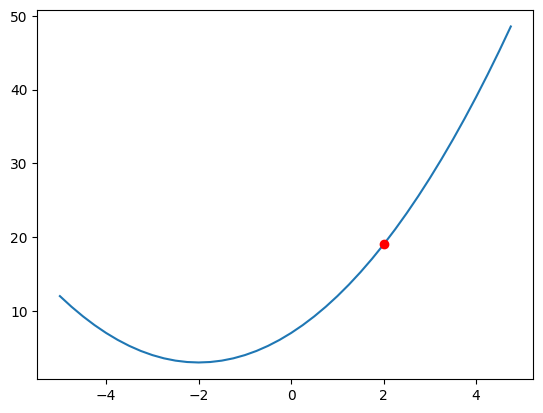

In [7]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
print(xs[5])
print(ys[5])
plt.plot(xs, ys)
a = f(2)
plt.plot(2, a, 'ro')

In [15]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'}) #LR c-a-d left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            
        # for any value in the graph, create a rectanular node for it
        
            dot.node(name = uid + n._op, label = n._op)

            # connect node to it

            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    image_filename = 'BackPropgraph.png'

    # Render the graph and save it as an image file
    dot.render(image_filename, format='png')

        
    return dot

        
    

In [9]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [7]:
# # inputs
# x1 = Value(2, label='x1')
# x2 = Value(0, label='x2')

# #weights
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')

# #bias of the neuron
# b = Value(6.88137, label='b')

# x1w1 = x1*w1; x1w1.label = 'x1w1'
# x2w2 = x2*w2; x2w2.label = 'x2w2'
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# n = x1w1x2w2 + b; n.label = 'n'

# e = (2*n).exp()
# o = (e -1) /  (e + 1)

# o = o.label = 'o'


In [8]:
# manually setting gradients
# n.grad = 1 - o.data**2
# o.grad = 1
# x1w1x2w2.grad = n.grad
# b.grad = n.grad
# x1w1.grad = n.grad
# x2w2.grad = n.grad

# w1.grad = x1.data * x1w1.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad

In [9]:
# o.backward()
# # manually setting values before using loop to do it
# # n._backward()
# # b._backward()
# # x1w1x2w2._backward()
# # x2w2._backward()
# # x1w1._backward()


In [10]:
# draw_dot(o)

In [11]:
# x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
# x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
# w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
# w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
# b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
# n = x1*w1 + x2*w2 + b
# o = torch.tanh(n)

# print(o.data.item())
# o.backward()

# print('---')
# print('x2', x2.grad.item())
# print('w2', w2.grad.item())
# print('x1', x1.grad.item())
# print('w1', w1.grad.item())

In [10]:
import random

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [11]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
# print(n.parameters())
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]


In [12]:
for k in range(20):
    
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 2.491958352051476
1 0.7422412112468125
2 0.4315971072564197
3 0.2989196962922871
4 0.2267169429009287
5 0.18168109654708584
6 0.15104952778192654
7 0.1289324504955802
8 0.1122498410652242
9 0.09923966295489048
10 0.08882324240682513
11 0.08030433688611313
12 0.07321401004306183
13 0.0672251817396259
14 0.062102943430683746
15 0.05767434120954654
16 0.053809287289993936
17 0.05040810280638475
18 0.047393155841478546
19 0.044703108251280654


In [13]:
n.layers[0].neurons[0].w[0].grad

0.008898715481229455

In [27]:
n.layers[0].neurons[0].w[0].data

-0.29282380831363586

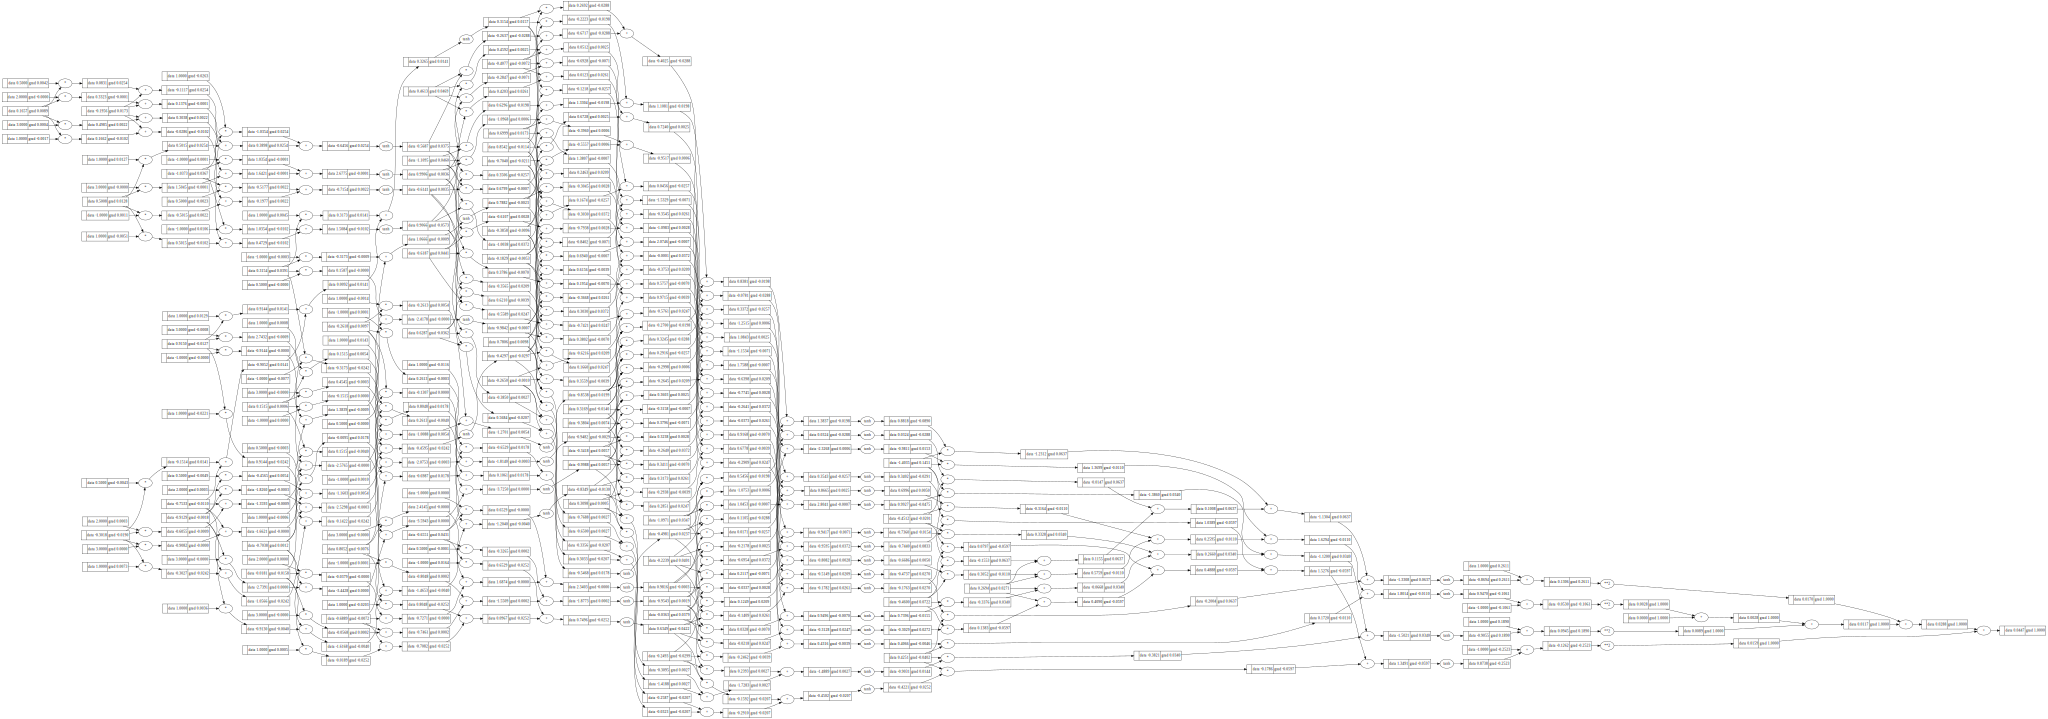

In [16]:
draw_dot(loss)